# Exercise 7.4

SINDy is an algorithm which allows to discover non-linear dynamic models from sparse data. It leverages the fact that dynamic systems, which can be generalized as $ \frac{d\vec{x}}{dt} = \vec{f}(\vec{x})$, typically present a dynamics $f$ with only a few active terms in the space of possible right-hand side functions. The idea behind Sindy is to find the approximation (1) with the highest number of $\xi_k$ equal to $0$ using **sparse regression**.

$$ \vec{f}(\vec{x}) \sim \sum_{k=1}^p \theta_k(\vec{x}) \vec{\xi}_k = \vec{\Theta}\vec{\xi} \,\,\,\,\,\,\,\,\,\,\,(1)$$

In order to apply sparse regression on a dynamic system, the set of equation is representd in the general form:

$$\dot{X} = \vec{\Theta}(\vec{x})\vec{\Xi} \,\,\,\,\,\,\,\,\,\,\,(2)$$

where $ \dot{X} $ is a matrix containing the derivative of the temporal sequence produced by the system, $ \vec{\Theta}(\vec{x}) $ is a fimily of candidate non-linear functions, which may be activated or not depending on $ \vec{\Xi} $, and $ \vec{\Xi} $ is a matrix whose colums are the activator $ \vec{\xi}_k $.

Regression is then implemented through the minimization of the Euclidean norm between $\dot{X}$ and its approximation plus a regularization term:

$$\vec{\xi}_k = argmin_{\vec{\xi}_k'} ||\dot{X}_k- \vec{\Theta}\vec{\xi}_k' ||_2 + \lambda||\vec{\xi}_k' ||_1\,\,\,\,\,\,\,\,\,\,\,(3)$$

## (a)

In [7]:
# From the book
import numpy as np
from scipy import integrate
import pysindy as ps
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error

# Import plotting libraries and tools.
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
np.random.seed(123)

**STEP 1**

The first thing to do is to produce a large dataset to train SINDy. Since we want to train SINDy on the solution of the Lorenz system the dataset will be composed of the trajectory evolution of $ (x,y,z) $ in time. Therefore, the relevant parameters which describe the dataset are:

- The total time-length of the trajectory that we simulate with numerical integration, which is called $T_{long}$.
- The time-length of a smaller trajectory, i.e. a subset of the initial dataset, which is indicated with $T<T_{long}$.
- The number of point in the dataset which desctibe a trajectory with a certain time-length, $r$.
- The size of the time-step used for numerical integration, which is called $\Delta t$.
- The period underling the Lorenz dynamic, calculated by averaging over many trips around the attractor, $\tau$.

In other words, $ T $ (or $ T_{long} $), $ r $ and $ \Delta t $ respect the following mathematical relations: $ T=r\cdot\Delta t $, $ \Delta t = T / r $ , $ r=T/\Delta t $.

**Note:** The nomencalture we used is inspired to article [Discovery of Non Linear Multiscale Systems: Sampling Strategies and Embeddings](https://arxiv.org/abs/1805.07411). 

In [8]:
# Define the time evolution of the Lorenz system. 
dt = 1e-4
tau = 0.759
T_long = tau * 20
t = np.arange( dt , T_long , dt )

**STEP 2**

The dataset can be generated via numerical integration of the well-known Lorenz system: 

\begin{align}
\dot{x} = \sigma(y-x)
\end{align}

\begin{align}
\dot{y} = x ( \rho - z ) - y
\end{align}

\begin{align}
\dot{z} = xy - \beta z
\end{align}

where $ \beta $, $ \sigma $ and $ \rho $ define a particular dynamic ans $ x_{0} $ are the initial conditions. In the following block of code, the Right-Hand-Side (RHS) of the Lorenz System is defined and the PDEs are integrated using the ```odeint``` method over the total length of the trajectory $ T_{long} $. Note that it is necessary to remove the first $ t=1 $ of the dataset itself as required from the exercise. 

In [9]:
# Define the system parameters.
beta = 8/3
sigma = 10
rho = 28
n = 3

# Define the Lorenz system RHS.
def lorenz_deriv( x_y_z , t0 , sigma = sigma , beta = beta, rho = rho ):
    x, y, z = x_y_z
    return [ sigma * (y - x) , x * (rho - z) - y, x * y - beta * z ]

# Define the starting conditions.
x0 = ( -8 , 8 , 27 )

# Integrate the Lorenz PDEs.
x = integrate.odeint( lorenz_deriv , x0 , t , rtol = 10**(-12) , atol = 10**(-12) * np.ones_like(x0) )

# Remove the first 1 second of the simulation.
x_train = x[ int( 1 / dt ) : , : ]

**STEP 3**

The vector $R$ contains a set of integers, $(r_0,...,r_n)$, which define ordinate subsamples of the full-dataset. The elements of $R$ are visited in a loop and used to cut the full dataset at different length. SINDy is trained on each of the $n$ dataset and its performance are monitored computing the Mean Squared Error $MSE$ and the r2 score $R2$ between the predictions and the training dataset.

The plots below show the metrics as functions of the different dataset sizes; it is possible to observe that the models predict with accuracy close to the full dataset even with a small fraction of the data. For the Lorenz System, $ R2\sim1 $ and $ MSE<<1 $ are already achieved around $ r_{i}=6581 $ time-steps, which corresponds to $ T = \Delta t \cdot r_i \sim 0.65 $.

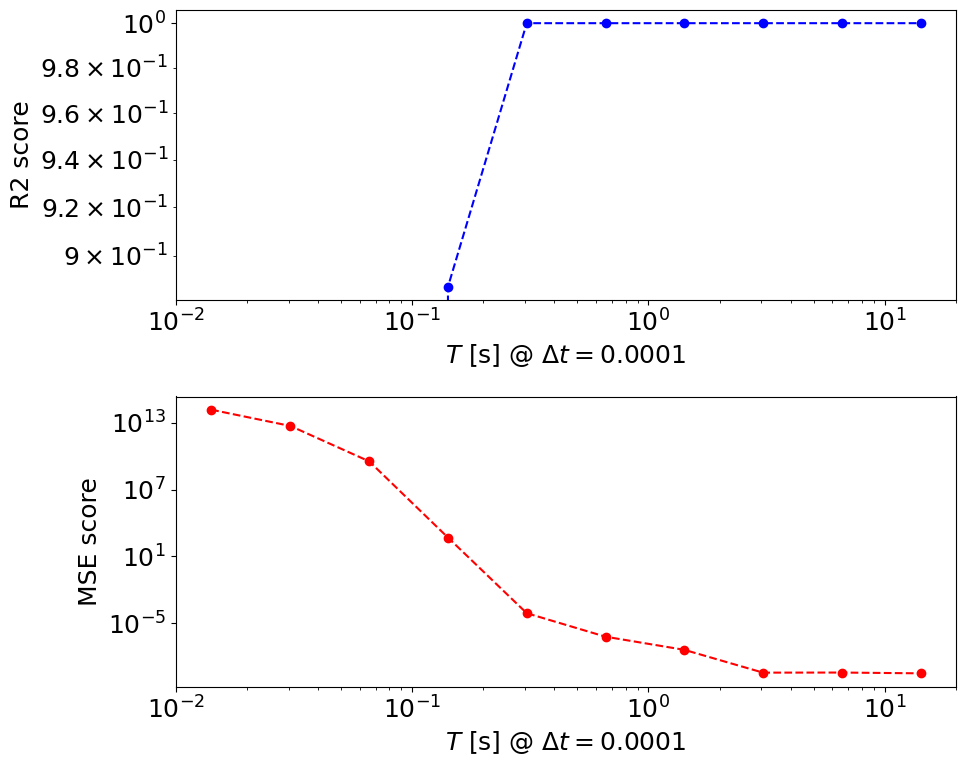

In [10]:
# train SINDy on several dataset with different length.
def trainer( R , feature_names , sparse_regression_optimizer ):

    # Compute the scores for different training set sizes.
    scores = []
    for r in R:
        x_frac = x_train[ : r , :]
        model = ps.SINDy( feature_names = feature_names , optimizer = sparse_regression_optimizer )
        model.fit( x_frac , t = dt )
        scores.append( [ model.score( x_train , t = dt, metric = metric) for metric in [ r2_score , mean_squared_error ] ] )
    scores = np.array(scores)
    
    return scores

# plot function.
def plot1( R , dt , scores ):
    
    # Plot the scores as log-log plots.
    fig = plt.figure( figsize = ( 10 , 8 ) )
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    ax1.loglog( R * dt , scores[:, 0] , label = '$R^2$', marker = 'o' , linestyle = '--' , color = "blue")
    ax2.loglog( R * dt , scores[:, 1] , label = 'MSE' , marker = 'o' , linestyle = '--' , color = "red" )
    
    ax1.set_xlabel( f'$T$ [s] @ $\Delta t = {dt}$' )
    ax2.set_xlabel( f'$T$ [s] @ $\Delta t = {dt}$' )  
    ax1.set_ylabel( "R2 score" )
    ax2.set_ylabel( "MSE score" )
    
    plt.tight_layout()
    plt.show()


# Define a set of shorter dataset.
R = ( x_train.shape[0] * np.logspace( - 3 , 0 , num = 10 ) ).astype(int) 
# Instantiate and fit the SINDy model.
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ( threshold = 0 )  # default is lambda = 0.1
# Train SINDy on each dataset and evaluate the performance.
scores = trainer( R , feature_names , sparse_regression_optimizer )
# Plot the performance.
plot1( R , dt , scores )

**STEP 4:**

Assuming that $ MSE $ and $ R2 $ are good metrics to evaluate SINDy performance, the dataset corresponding to the $ 5^{th} $ point in the plots above is selected. It contains a trajectory of length $ T \sim 0.8 $ with time-step  $ dt = 0.0001 $, corresponding to $ r = T/dt \sim 8 \cdot 10^3 $ points. Then, SINDy is trained and system dynamic is extracted.

In [11]:
# Select the shorter length of the dataset with r2_scose ~ 1.
r5 = R[5]
x_frac = x_train[ : r5 , :]

# Fit the SINDy model over the short dataset.
model = ps.SINDy( feature_names = feature_names , optimizer = sparse_regression_optimizer )
model.fit( x_frac , t = dt )

# Print the model outcome.
print("DYNAMIC SYSTEM PREDICTED BY SINDY:")
model.print()
print("\n ALL COEFFICIENTS:\n", np.round( model.coefficients() , 3 ) )
print("MODEL SPECIFICATIONS:")
print(model.differentiate)

DYNAMIC SYSTEM PREDICTED BY SINDY:
(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

 ALL COEFFICIENTS:
 [[ -0.    -10.     10.      0.      0.     -0.     -0.     -0.     -0.
   -0.   ]
 [ -0.     28.     -1.      0.     -0.      0.     -1.     -0.     -0.
   -0.   ]
 [ -0.      0.     -0.     -2.667   0.      1.     -0.     -0.     -0.
   -0.   ]]
MODEL SPECIFICATIONS:
<bound method SINDy.differentiate of SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(threshold=0))>


Recall that the problem was initialized with  $ \sigma = 10 $, $ \beta=8/3 $ and $ \rho=28 $. Consequently the Lorenz system can be written explicitely as:

\begin{align}
\dot{x} = 10(y-x)
\end{align}

\begin{align}
\dot{y} = x ( 28 - z ) - y
\end{align}

\begin{align}
\dot{z} = xy - 2.667 z
\end{align}

The result that we obtained above show that, for this choice of $ r $ , $ T $ and $ \Delta t $ , SINDy is perfectly able to recover the exact non-linear dynamics from the sparse data.

**STEP 5:** 

The Lorenz Trajectories obtained with SINDy for the full dataset $T=15.18$ and for the dataset used in **STEP 4** to train SINDy $T=0.65$ are plotted together with the starting cinditions. It is very surprising that SINDy can discover the correct Lorenz dynamic when trained on a trajectory which lasts less than one period of the Lorenz system! This may depend on the fact that the Lorenz dynamic is strongly dependent on the starting conditions.

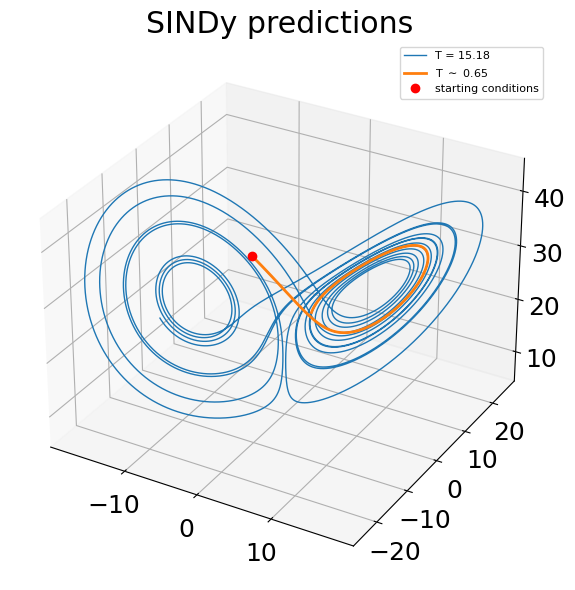

In [12]:
def plot2( SINDy_pred_Tmin , x0 ):
    
    plt.close()

    fig1 , ax = plt.subplots( 1 , 1 , subplot_kw = { 'projection' : '3d' } , figsize = ( 7 , 7 ) )
    x, y, z = SINDy_pred_T.T
    xmin , ymin , zmin = SINDy_pred_Tmin
    plt.plot( x , y , z , linewidth = 1 , label = "T = " + str(T_long) )
    plt.plot( xmin , ymin , zmin , linewidth = 2 , label = "T $\sim$ 0.65" )
    plt.plot( x0[0] , x0[1] , x0[2] , "o" , color = 'r' , label = "starting conditions" )
    plt.title( "SINDy predictions" )
    plt.legend( prop = {'size': 8} )
    plt.show()

# Make predictions on the two trajectories using SINDy.
t = np.arange( dt , T_long , dt )
SINDy_pred_T = model.simulate( x0 , t )
SINDy_pred_Tmin = model.simulate( x0 , np.arange( dt , r5 * dt , dt ) )

# Plot the predictions.
plot2( SINDy_pred_Tmin.T , x0 )

# (b) 

The relation which underlines the convergence of SINDy depending on $ r $ and $ \Delta t $ is discovered via the following algorithm:

1) We assume that the SINDy model converges to the Lorenz System when: $ ( MSE<10^{-4} )\wedge( 0.8<R2<1.2 ) $. 
2) Given a time-step magnitude $ dt_i $ , $ i=0,...,k $, we train SINDy for progressively larger dataset $ r_j $, $ j=0,...,m $ in a double for loop.
3) Per each $ dt_i $ we keep only the smaller $ r_j $ which satisfies point (1).

Now we can plot all the pairs $ (T,\Delta t) $ and $ (T,\Delta t) $ which respect condition (1). The result shows that SINDy is very sensible to the size of the time step $\Delta t$. The result we obtained is not trivial because it shows that:
- **Plot 1:** It looks as if there are different ranges where $ r $ progressively dicrease as $ dt $, for example $ \Delta t \in (10^{-4} , 2\cdot 10^{-4}) $ or in $ \Delta t \in (2\cdot 10^{-4},10^{-3}) $. However, this may depend also on how we defined ```R``` and ```Dt``` in the algorithm.
- **Plot 2:** as $ dt $ increases, the length of the trajectory $ T $ also increases. This is an anexpected result, because it means that SINDy is more sensible to the size of the time-step than to the length of the trajectory. It prefers smaller time-step than longer trajectories. However, once again this may depend on how we defined ```R``` and ```Dt``` and a deeper study should be necessary to give a more appropriated answer.

**Recall that:**
- ```Dt``` is a vector which contains $ dt_0,...dt_k $, i.e. different time-step.
- ```R``` is a vector which contains $ r_0, ..., r_m $, i.e. different number of points to define the dataset.

In [13]:
def relation_discover( Dt , tau = tau , x0 = x0 , beta = beta , sigma = sigma , rho = rho , feature_names = feature_names , sparse_regression_optimizer = sparse_regression_optimizer):

    # Define the Lorenz system RHS.
    def lorenz_deriv( x_y_z , t0 , sigma = sigma , beta = beta, rho = rho ):
        x, y, z = x_y_z
        return [ sigma * (y - x) , x * (rho - z) - y, x * y - beta * z ]

    rs = []
    dts = []
    i = 0
     
    for dt in Dt: 
        
        # Create a new dataset with temporal spacing dt.
        t = np.arange( dt , tau * 20 , dt )
        x_train = integrate.odeint( lorenz_deriv , x0 , t , rtol = 10**(-12) , atol = 10**(-12) * np.ones_like(x0) )
        R = np.unique( ( x_train.shape[0] * np.logspace( - 2 , 0 , num = 200 ) ).astype(int) )
        R = R[ 3 < R ]
        
        for r in R:    
            
            # Select dataset with r points.
            x_frac = x_train[ : r , :]

            # Train Sindy 
            model = ps.SINDy( feature_names = feature_names , optimizer = sparse_regression_optimizer )
            model.fit( x_frac , t = dt  )
            MSE = model.score( x_train , t = dt , metric = mean_squared_error )
            R2 = model.score( x_train , t = dt , metric = r2_score )
        
            if ( MSE < 1e-4 ) and ( 0.8 < R2 < 1.2 ):
                dts.append( dt )
                rs.append( r ) 
                break
                
    return np.array(dts) , np.array(rs)

# Define different time-step size.
Dt = np.logspace( - 4 , - 1 , num = 100 )
# Implement the algorithm in the description.
dts , rs = relation_discover( Dt )

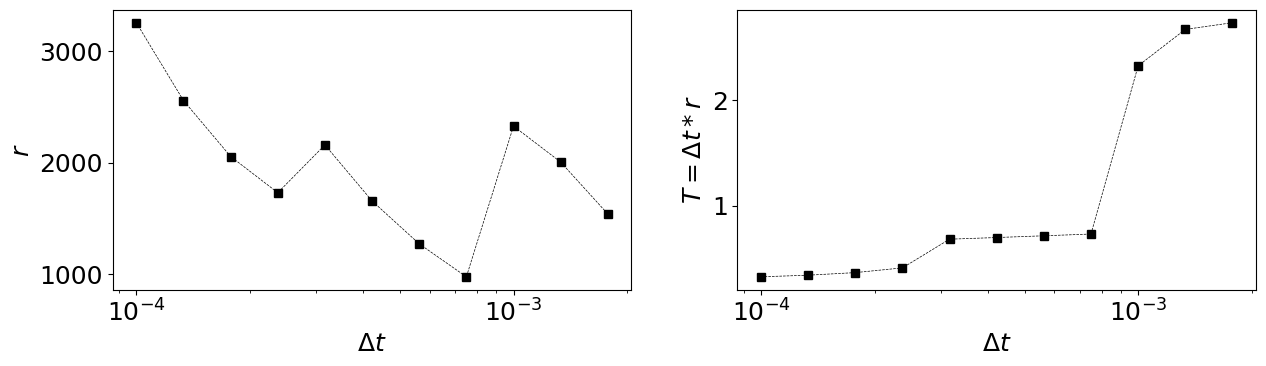

In [14]:
def plot3( dts , rs ):
    
    plt.close()

    fig = plt.figure( figsize = ( 13 , 4 ) )
    ax1 = fig.add_subplot( 121 )
    ax2 = fig.add_subplot( 122 )
    
    ax1.plot( dts , rs , marker = "s" , linestyle = "--" , linewidth = 0.5 , color = "black" )
    ax1.set_xscale( "log" )
    ax1.set_ylabel("$r$")
    ax1.set_xlabel("$\Delta t$ ")
    
    ax2.plot( dts , dts * rs , marker = "s" , linestyle = "--" ,linewidth = 0.5 , color = "black" )
    ax2.set_xscale( "log" )
    ax2.set_ylabel("$T = \Delta t * r$")
    ax2.set_xlabel("$\Delta t$ ")

    plt.tight_layout()
    plt.show()
    
# Plot the result.
plot3( dts , rs )

# (c)

**STEP 1**

Firstly, three different distibutions are chosen, ( the Gaussian, the Exponential and the Poisson) with different means and standard deviations. The corresponding numpy functions are used to produce noise according to these distributions and the noise is summed to the shorter Lorenz trajectory $ T=0.65 $. Below, both the noise itself and the corresponding "Lorenz randomised trajectories" are plotted:
- **NOISE 1** : Gaussian distribution with $ \mu=0 $ and $ \sigma = 0.001 $.
- **NOISE 2** : Exponential distribution with $ \mu = 0.1 $ and $ \sigma = 0.01 $.
- **NOISE 3** : Poisson distribution with $ \mu=0.5 $ and $ \sigma = 0.5 $.

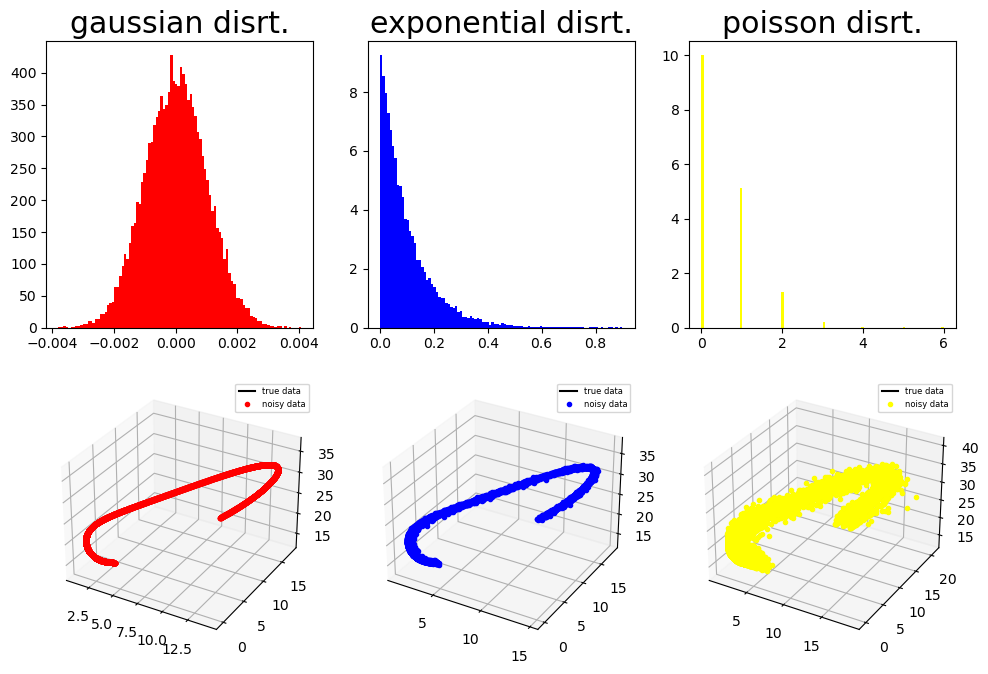

In [15]:
# Plot function.
def plot4( noise1 , x_frac1 , noise2 , x_frac2 , noise3 , x_frac3 ):
    plt.close()

    fig = plt.figure( figsize = ( 10 , 7 ) )
    ax1 = fig.add_subplot( 231 )
    ax2 = fig.add_subplot( 232 )
    ax3 = fig.add_subplot( 233 )
    ax4 = fig.add_subplot( 234 , projection = '3d' )
    ax5 = fig.add_subplot( 235 , projection = '3d' )
    ax6 = fig.add_subplot( 236 , projection = '3d' )

    for ax , noise , label ,  c in zip( [ax1, ax2, ax3] , [noise1 , noise2 , noise3 ] , ["gaussian" , "exponential" , "poisson" ] , ["red" , "blue" , "yellow"]):
        ax.hist( noise.flatten() , 100 , color = c , density = True )
        ax.set_title(label+" disrt.")
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    for ax , data , label ,  c in zip( [ax4, ax5, ax6] , [x_frac1 , x_frac2 , x_frac3 ] , ["gaussian" , "exponential" , "poisson" ] , ["red" , "blue" , "yellow"]):
        ax.plot( x_frac[ : , 0 ] , x_frac[ : , 1 ] , x_frac[ : , 2 ] , color = "black" ,  label = "true data" )
        ax.plot( data[ : , 0 ] , data[ : , 1 ] , data[ : , 2 ] , "." , color = c , label = "noisy data" )
        ax.legend( loc = "upper right" , prop={'size': 6})
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

# Define the dataset dimension.
x_frac = x_train[ : 6581 , : ]
dt = 0.0001

# Produce noise.
noise1 = np.random.normal( 0 , 0.001 , x_frac.shape )
noise2 = np.random.exponential( 0.1 , x_frac.shape )
noise3 = np.random.poisson( 0.5 , x_frac.shape )

# Add noise to the dataset.
x_frac1 = x_frac + noise1
x_frac2 = x_frac + noise2
x_frac3 = x_frac + noise3

# Plot noisy dataset.
plot4( noise1 , x_frac1 , noise2 , x_frac2 , noise3 , x_frac3 )

**STEP 2**

The randomized trajectories are used to fit SINDy, the $ MSE $ and the $ R2 $ are evaluated afterwards. By plotting the model results, the $ MSE $ and the $ R2 $, we can observe that noisy data strongly compomise SINDy outcome. Reasonable performance are obtained only with **NOISE 1**, this is not surprising because we used a null mean and a very small variance.

In [16]:
def noisy_trainer(  x_frac_noisy , dt = dt , x_frac = x_frac , feature_names = feature_names , optimizer = sparse_regression_optimizer ):
    
    # Fit the SINDy model over the short dataset.
    model = ps.SINDy( feature_names = feature_names , optimizer = sparse_regression_optimizer )
    model.fit( x_frac_noisy , t = dt )
    MSE = model.score( x_frac , t = dt , metric = mean_squared_error )
    R2 = model.score( x_frac , t = dt , metric = r2_score )

    # Print the model outcome.
    print("PREDICTIONS:")
    model.print()
    print("MSE = ", MSE , " R = ", R2)
    
    return model

# Evaluate SINDy on the noisy trajectories. 
print("\n>>>Gaussian Noise:")
model1 = noisy_trainer( x_frac1 ) 
print("\n>>>Exponential Noise:")
model2 = noisy_trainer( x_frac2 )
print("\n>>>Poisson Noise:")
model3 = noisy_trainer( x_frac3 )


>>>Gaussian Noise:
PREDICTIONS:
(x)' = -5.897 1 + 2.140 x + 4.264 y + 1.119 z + 0.655 x^2 + -0.136 x y + -0.409 x z + -0.095 y^2 + 0.107 y z + -0.050 z^2
(y)' = -0.951 1 + 35.951 x + -4.832 y + 0.522 z + 0.464 x^2 + -0.049 x y + -1.278 x z + -0.069 y^2 + 0.052 y z + -0.029 z^2
(z)' = -1.077 1 + 4.025 x + -1.887 y + -2.448 z + 0.219 x^2 + 0.925 x y + -0.145 x z + -0.021 y^2 + 0.047 y z + -0.011 z^2
MSE =  0.0010356977312915513  R =  0.9999995478122181

>>>Exponential Noise:
PREDICTIONS:
(x)' = 101.030 1 + -109.390 x + 63.394 y + -5.021 z + -5.453 x^2 + 8.853 x y + 4.097 x z + -1.786 y^2 + -3.508 y z + 0.087 z^2
(y)' = 168.583 1 + -164.360 x + 92.782 y + -2.129 z + -9.755 x^2 + 17.078 x y + 7.283 x z + -3.206 y^2 + -6.999 y z + -0.143 z^2
(z)' = 453.547 1 + -127.843 x + 53.611 y + -43.191 z + -2.093 x^2 + 8.350 x y + 2.814 x z + -0.102 y^2 + -3.726 y z + 1.159 z^2
MSE =  42.63977802278808  R =  0.9869473946268553

>>>Poisson Noise:
PREDICTIONS:
(x)' = 2356.569 1 + 669.471 x + -311.695 y

**STEP 3**

The entire Lorenz trajectory (with $ T=15.18 $) was then used to fit the SINDy model, with results which are nicer but not perfect yet. This highlight that SINDy is highly instable in the face of noisy data, but as the tragectory get longer, it can still learn the dynamic fearly well.

In [17]:
# Add small gaussian noise to the full trajectory.
noise = np.random.normal( 0 , 0.1 , x_train.shape )
x_train_noisy = x_train + noise
# Evaluate SINDy performance.
print("\n>>>Small Gaussian Noise:")
model4 = noisy_trainer( x_train_noisy )


>>>Small Gaussian Noise:
PREDICTIONS:
(x)' = 0.094 1 + -9.554 x + 9.720 y + 0.007 x^2 + -0.002 x y + -0.012 x z + -0.002 y^2 + 0.007 y z + -0.001 z^2
(y)' = 1.010 1 + 28.156 x + -1.083 y + -0.149 z + -0.027 x^2 + 0.027 x y + -1.004 x z + -0.007 y^2 + 0.002 y z + 0.005 z^2
(z)' = 1.836 1 + -0.036 x + 0.036 y + -2.937 z + -0.050 x^2 + 1.043 x y + 0.001 x z + -0.007 y^2 + -0.001 y z + 0.009 z^2
MSE =  0.0272501144595944  R =  0.9999920477619888


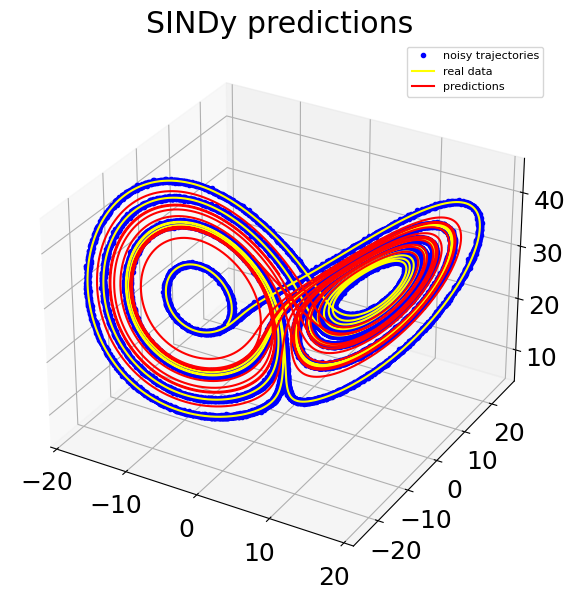

In [18]:
t = np.arange( dt , T_long , dt )
pred = model4.simulate( x0 , t )

def plot5( x_train , x_train_noisy , pred ):
    
    plt.close()
    fig , ax = plt.subplots( 1 , 1 , subplot_kw = { 'projection' : '3d' } , figsize = ( 7 , 7 ) )
    x, y, z = SINDy_pred_T.T
    plt.plot( x_train_noisy[ : , 0 ] , x_train_noisy[ : , 1 ] , x_train_noisy[ : , 2 ] , '.' , color = "blue" , label = "noisy trajectories")
    plt.plot( x_train[ : , 0 ] , x_train[ : , 1 ] , x_train[ : , 2 ]  , color = "yellow" , label = "real data")
    plt.plot( pred[ : , 0 ] , pred[ : , 1 ] , pred[ : , 2 ]  , color = "red" , label = "predictions")
    plt.title( "SINDy predictions" )
    plt.legend( prop = {'size': 8} )
    plt.show()

plot5( x_train , x_train_noisy , pred )